In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtyping import TensorType
import matplotlib.pyplot as plt

In [70]:
class TensorVMSplitEncoding(nn.Module):
    """Learned vector-matrix encoding proposed by TensoRF

    Args:
        resolution: Resolution of grid.
        num_components: Number of components per dimension.
        init_scale: Initialization scale.
    """

    # plane_coef: TensorType[3, "num_components", "resolution", "resolution"]
    # line_coef: TensorType[3, "num_components", "resolution", 1]

    vec_modes = [[0,1], [0,2], [1,2]]
    app_modes = [2, 1, 0]

    def __init__(
        self,
        resolution: int = 128,
        num_components: int = 24,
        init_scale: float = 0.1,
        agg_mode='ADD',
        pair_mode='MUL',
    ) -> None:
        super().__init__()

        self.register_buffer("resolution", torch.Tensor([resolution,]*3).to(dtype=int))
        self.num_components = num_components
        self.agg_mode = agg_mode
        self.pair_mode = pair_mode

        if self.agg_mode == 'MUL':
            init_scale = .7

        plane_coef, line_coef = [], []

        for _ in range(3):
            plane_coef.append(nn.Parameter(init_scale * torch.randn((1, num_components, resolution, resolution))))
            line_coef.append(nn.Parameter(init_scale * torch.randn((1, num_components, resolution, 1))))
        
        self.plane_coef = nn.ParameterList(plane_coef)
        self.line_coef = nn.ParameterList(line_coef)

    def get_out_dim(self) -> int:
        if self.agg_mode == 'MUL' or self.agg_mode == 'ADD':
            return self.num_components
        else:
            return self.num_components * 3

    @torch.no_grad()
    def forward(self, in_tensor: TensorType["bs":..., "input_dim"]) -> TensorType["bs":..., "output_dim"]:
        """Compute encoding for each position in in_positions

        Args:
            in_tensor: position inside bounds in range [-1,1],

        Returns: Encoded position
        """
        plane_coord = torch.stack([in_tensor[..., [0, 1]], in_tensor[..., [0, 2]], in_tensor[..., [1, 2]]])  # [3,...,2]
        line_coord = torch.stack([in_tensor[..., 2], in_tensor[..., 1], in_tensor[..., 0]])  # [3, ...]
        line_coord = torch.stack([torch.zeros_like(line_coord), line_coord], dim=-1)  # [3, ...., 2]

        # Stop gradients from going to sampler
        plane_coord = plane_coord.view(3, -1, 1, 2).detach()
        line_coord = line_coord.view(3, -1, 1, 2).detach()

        # plane_features = F.grid_sample(self.plane_coef, plane_coord, align_corners=True)  # [3, Components, -1, 1]
        # line_features = F.grid_sample(self.line_coef, line_coord, align_corners=True)  # [3, Components, -1, 1]

        plane_features, line_features = [], []
        for idx_plane in range(len(self.plane_coef)):
            plane_features.append(F.grid_sample(self.plane_coef[idx_plane], plane_coord[[idx_plane]], align_corners=True))
            line_features.append(F.grid_sample(self.line_coef[idx_plane], line_coord[[idx_plane]], align_corners=True))

        plane_features = torch.cat(plane_features, dim=0)
        line_features = torch.cat(line_features, dim=0)

        if self.pair_mode == 'ADD':
            features = plane_features + line_features  # [3, Components, -1, 1]
        else:
            features = plane_features * line_features  # [3, Components, -1, 1]

        if self.agg_mode == 'MUL':
            features = features[0] * features[1] * features[2]
            features = torch.moveaxis(features.view(self.num_components, *in_tensor.shape[:-1]), 0, -1)
        elif self.agg_mode == 'ADD':
            features = torch.sum(features, dim=0)
            features = torch.moveaxis(features.view(self.num_components, *in_tensor.shape[:-1]), 0, -1)
        else:
            features = torch.moveaxis(features.view(3 * self.num_components, *in_tensor.shape[:-1]), 0, -1)

        return features  # [..., 3 * Components]

In [8]:
vm0 = TensorVMSplitEncoding(resolution=128, num_components=16, init_scale=0.1, agg_mode='ADD')

In [9]:
random_pos = torch.empty((1000, 3)).uniform_(-1, 1)

## ADD AGG

In [10]:
dens = vm0(random_pos)

(array([  1.,   1.,  94., 418., 411.,  67.,   7.,   1.]),
 array([-0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ]),
 <BarContainer object of 8 artists>)

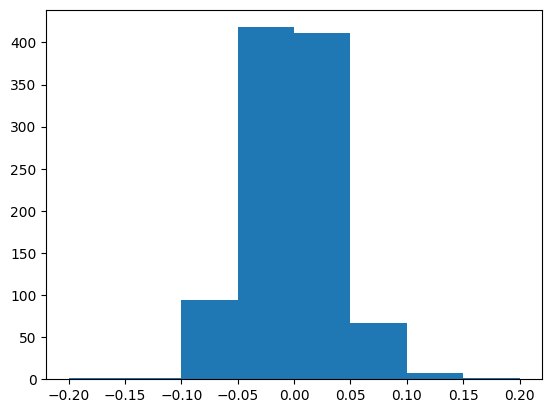

In [11]:
plt.hist(dens.sum(-1), bins=[-0.20,-0.15,-0.10,-0.05,0,0.05,0.10,0.15,0.20])

(array([   3.,   15.,   84.,  456., 1963., 1200.,  226.,   37.,   11.,
           5.]),
 array([-0.05198875, -0.04117449, -0.03036022, -0.01954595, -0.00873169,
         0.00208258,  0.01289684,  0.02371111,  0.03452537,  0.04533964,
         0.0561539 ], dtype=float32),
 <BarContainer object of 10 artists>)

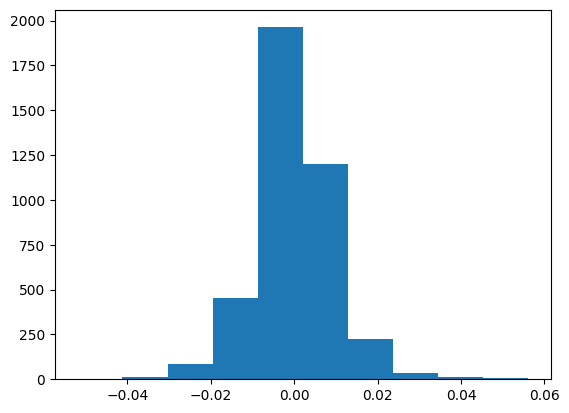

In [12]:
plt.hist(dens.reshape(-1)[:4000])

## MUL AGG

In [71]:
vm1 = TensorVMSplitEncoding(resolution=128, num_components=16, init_scale=0.1, agg_mode='MUL')

In [72]:
dens = vm1(random_pos)

(array([ 20.,  35.,  86., 341., 383.,  74.,  21.,  10.]),
 array([-0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ]),
 <BarContainer object of 8 artists>)

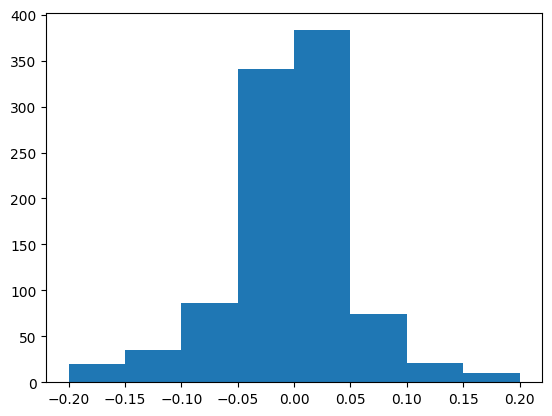

In [73]:
plt.hist(dens.sum(-1), bins=[-0.20,-0.15,-0.10,-0.05,0,0.05,0.10,0.15,0.20])

(array([2.000e+00, 7.000e+00, 3.825e+03, 1.610e+02, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-5.78114019e-08, -3.79729599e-08, -1.81345143e-08,  1.70392944e-09,
         2.15423732e-08,  4.13808152e-08,  6.12192608e-08,  8.10577063e-08,
         1.00896145e-07,  1.20734597e-07,  1.40573036e-07], dtype=float32),
 <BarContainer object of 10 artists>)

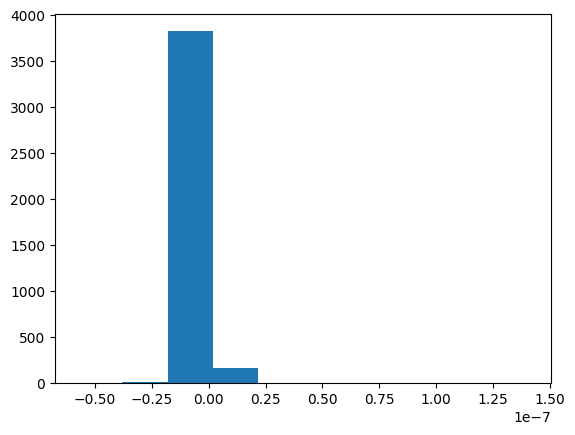

In [35]:
plt.hist(dens.reshape(-1)[:4000])

## MUL AGG SMALLER

In [18]:
vm1 = TensorVMSplitEncoding(resolution=128, num_components=16, init_scale=0.1, agg_mode='MUL')

In [19]:
dens = vm1(random_pos)

(array([  1.,   0.,   1.,   3.,   1.,  23., 683., 271.,  14.,   3.]),
 array([-9790491., -8372374., -6954257., -5536140., -4118023., -2699906.,
        -1281789.,   136328.,  1554445.,  2972562.,  4390679.],
       dtype=float32),
 <BarContainer object of 10 artists>)

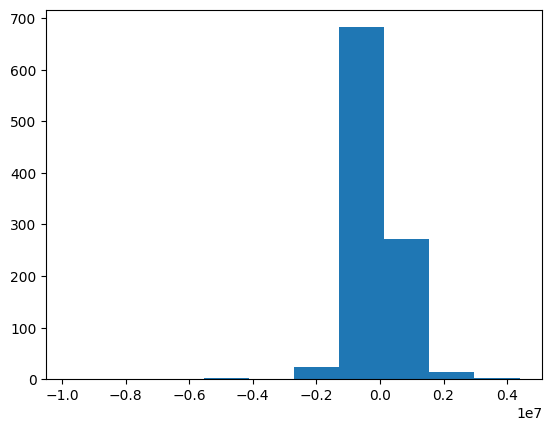

In [20]:
plt.hist(dens.sum(-1))

## ADD PAIR

In [21]:
vm2 = TensorVMSplitEncoding(resolution=128, num_components=16, init_scale=0.1, agg_mode='ADD', pair_mode='ADD')

In [22]:
dens = vm2(random_pos)

(array([  5.,   8.,  46., 151., 237., 269., 177.,  81.,  19.,   7.]),
 array([-2.5320299 , -2.035117  , -1.5382041 , -1.0412911 , -0.5443782 ,
        -0.04746532,  0.44944757,  0.94636047,  1.4432734 ,  1.9401863 ,
         2.4370992 ], dtype=float32),
 <BarContainer object of 10 artists>)

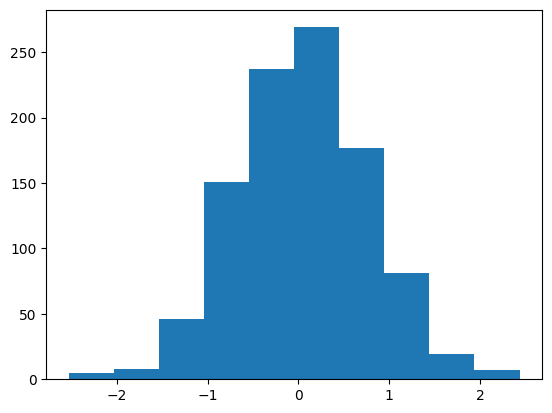

In [23]:
plt.hist(dens.sum(-1))

(array([  5.,   8.,  46., 151., 237., 269., 177.,  81.,  19.,   7.]),
 array([-2.5320299 , -2.035117  , -1.5382041 , -1.0412911 , -0.5443782 ,
        -0.04746532,  0.44944757,  0.94636047,  1.4432734 ,  1.9401863 ,
         2.4370992 ], dtype=float32),
 <BarContainer object of 10 artists>)

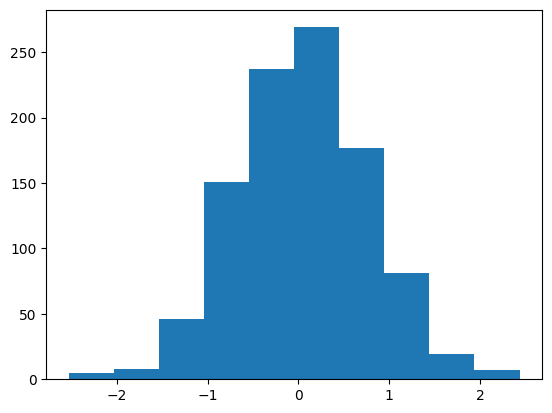

In [24]:
plt.hist(dens.sum(-1))